# Stock Price Predictor

In [66]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt 
import pandas_datareader as web 
import yfinance as yf  
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

layers = keras.layers
models = keras.models
Dense = layers.Dense 
Dropout = layers.Dropout
LSTM = layers.LSTM


# loading the data

In [67]:
company  = 'GOOG'

start = dt.datetime(2014,1,1)
end = dt.datetime(2023,1,1)

# Fetch stock data using yfinance
data = yf.download(company, start=start, end=end)

# got some error so just Checking if data is fetched properly
if data.empty:
    raise ValueError("Error: No stock data found! Check ticker symbol or date range.")


# Its prep time 
# Scaling down coz we know LSTM can perfomr better with scaldd inputs 
scaler = MinMaxScaler(feature_range=(0,1))

if 'Close' not in data.columns:
    raise ValueError("Error: 'Close' column not found in stock data!")

# using adjusted close should give better results 
# but i just wanna go with close as when i look into the data it looks like 
# it is always adjusted for stock splits (maybe wrong)
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# how many days to look back hmm ?maybe 2 or 3 months ?
prediction_days = 60

# creating the training data
x_train  = []
y_train = []

# I will add the 60(prediction_days ) no of data values and the next value as 
# the training example
# basically I am preparing the traing data such that the model get the 60 first values and
# the next day value so that model learns to predict the next day value gonna be 

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# The reshape line was missing an extra pair of parentheses
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[*********************100%***********************]  1 of 1 completed


# Building the model
using mean_squared_error - (Punishes large errors more heavily than small ones, making the model more precise.) and Adaptive moment Estimation (as it It adjusts the learning rate dynamically for each parameter during training.)
I am using LSTM as that remembers long-term dependencies. and Unlike normal RNNs, LSTM solves vanishing gradient issues using gates (Forget, Input, and Output gates).

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0324
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0024
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0025
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0022
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0023
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0021
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0019
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0026
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0017
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0018
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0016
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0021
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0016
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0017
Epoch 15/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0015
Epoc

[*********************100%***********************]  1 of 1 completed

 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


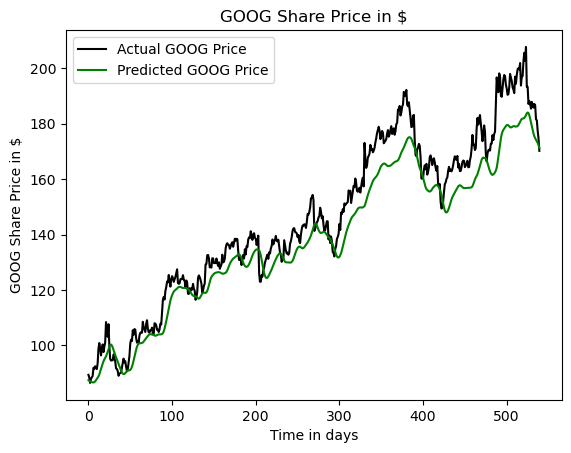

In [68]:
model = models.Sequential()


# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))


# Third LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25,batch_size=32)

'''Just Testing the Modal Accuracy on Existing Data :) else whats the point !?! '''

# lemme load the test data 
test_start = dt.datetime(2023,1,1)
test_end = dt.datetime.now()

test_data =  yf.download(company, start=test_start, end=test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'],test_data['Close']),axis=0)

inputs_for_model = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
inputs_for_model = inputs_for_model.reshape(-1,1)
inputs_for_model = scaler.transform(inputs_for_model)

# lets now make the predictions

x_test = []
for x in range(prediction_days,len(inputs_for_model)):
    x_test.append(inputs_for_model[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
# as the predicted prices are scaled kinda need to reverse rescale them
predicted_prices = scaler.inverse_transform(predicted_prices)

# Ploting the test Predictions
plt.plot(actual_prices,color = "black",label = f'Actual {company} Price')
plt.plot(predicted_prices,color = "green",label = f'Predicted {company} Price')
plt.title(f'{company} Share Price in $')
plt.xlabel('Time in days')
plt.ylabel(f'{company} Share Price in $')
plt.legend()
plt.show()

In [69]:
# predicting the Next Day!!! now do i become a Quant dev ? nah no really improving my cp and maths game still lol 

real_data = [inputs_for_model[len(inputs_for_model)+1 - prediction_days:len(inputs_for_model+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

prediction  = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction : {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Prediction : [[169.93678]]


during this prediction GOOG stock price was 170.21